**Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.**



In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

**First, load the dataset.**



In [3]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "lifeexpectancy"
table_name = "lifeexpectancy"

<IPython.core.display.Javascript object>

In [4]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()


<IPython.core.display.Javascript object>

## Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.##



In [5]:
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

# Initial EDA #

In [6]:
# df.head(50)

<IPython.core.display.Javascript object>

* Just looking at Afghanistan:
    * You can already see that the population of afghanistan swings wildly above, definitely due to input error. We'll have to figure out how to fix that. Perhaps either by looking at outliers in growth rates or outliers of the populations themselves within the country.

    * Also adult mortality drops to 3 in 2002, right after the US invasion.
* In Albania, you can see the adult mortality and percentage expenditure jumping around by a factor of 10.
* How to correct for errors like these?
Also, I'm assuming many of these stats are per 10,000 people.

In [7]:
# make a copy so I don't have to reload the dataset if I change something
df1 = df.copy()
df1.info()
# Looks like the data is correctly loaded into the right datatype.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

<IPython.core.display.Javascript object>

In [8]:
# seems like i have some extra whitespace in column names
df1 = df.rename(columns=lambda x: "_".join(x.strip().split()))

<IPython.core.display.Javascript object>

In [9]:
# Take a look at the string variables:
print(df1.Country.value_counts().sort_values()[0:20])
print("No. countries: " + str(df1.Country.nunique()))
print(df1.Status.unique())

Dominica                  1
Nauru                     1
Saint Kitts and Nevis     1
Tuvalu                    1
Palau                     1
Marshall Islands          1
Cook Islands              1
Niue                      1
San Marino                1
Monaco                    1
Iceland                  16
Dominican Republic       16
Costa Rica               16
Pakistan                 16
Haiti                    16
Ethiopia                 16
Greece                   16
Austria                  16
Philippines              16
Kyrgyzstan               16
Name: Country, dtype: int64
No. countries: 193
['Developing' 'Developed']


<IPython.core.display.Javascript object>

You can see that you have some countries entered only once, but nothing in the categorical 

In [10]:
# Percentage null:
print(df1.isnull().sum() / df1.isnull().count())
df1.set_index("Country").isnull().groupby(level=0).mean().head(10)

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life_expectancy                    0.003404
Adult_Mortality                    0.003404
infant_deaths                      0.000000
Alcohol                            0.066031
percentage_expenditure             0.000000
Hepatitis_B                        0.188223
Measles                            0.000000
BMI                                0.011572
under-five_deaths                  0.000000
Polio                              0.006467
Total_expenditure                  0.076923
Diphtheria                         0.006467
HIV/AIDS                           0.000000
GDP                                0.152485
Population                         0.221920
thinness_1-19_years                0.011572
thinness_5-9_years                 0.011572
Income_composition_of_resources    0.056841
Schooling                          0.055480
dtype: float64


Year  Status  Life_expectancy  Adult_Mortality  \
Country                                                               
Afghanistan           0.0     0.0              0.0              0.0   
Albania               0.0     0.0              0.0              0.0   
Algeria               0.0     0.0              0.0              0.0   
Angola                0.0     0.0              0.0              0.0   
Antigua and Barbuda   0.0     0.0              0.0              0.0   
Argentina             0.0     0.0              0.0              0.0   
Armenia               0.0     0.0              0.0              0.0   
Australia             0.0     0.0              0.0              0.0   
Austria               0.0     0.0              0.0              0.0   
Azerbaijan            0.0     0.0              0.0              0.0   

                     infant_deaths  Alcohol  percentage_expenditure  \
Country                                                               
Afghanistan                    0.0   0.0000                     0.0   
Albania                        0.0   0.0000                     0.0   
Algeria                        0.0   0.0625                     0.0   
Angola                         0.0   0.0625                     0.0   
Antigua and Barbuda            0.0   0.0625                     0.0   
Argentina                      0.0   0.0625                     0.0   
Armenia                        0.0   0.0625                     0.0   
Australia                      0.0   0.0625                     0.0   
Austria                        0.0   0.0625                     0.0   
Azerbaijan                     0.0   0.0625                     0.0   

                     Hepatitis_B  Measles  BMI  under-five_deaths  Polio  \
Country                                                                    
Afghanistan               0.0000      0.0  0.0                0.0    0.0   
Albania                   0.0000      0.0  0.0                0.0    0.0   
Algeria                   0.2500      0.0  0.0                0.0    0.0   
Angola                    0.4375      0.0  0.0                0.0    0.0   
Antigua and Barbuda       0.0625      0.0  0.0                0.0    0.0   
Argentina                 0.1250      0.0  0.0                0.0    0.0   
Armenia                   0.0000      0.0  0.0                0.0    0.0   
Australia                 0.0625      0.0  0.0                0.0    0.0   
Austria                   0.0000      0.0  0.0                0.0    0.0   
Azerbaijan                0.1250      0.0  0.0                0.0    0.0   

                     Total_expenditure  Diphtheria  HIV/AIDS  GDP  Population  \
Country                                                                         
Afghanistan                     0.0000         0.0       0.0  0.0         0.0   
Albania                         0.0000         0.0       0.0  0.0         0.0   
Algeria                         0.0625         0.0       0.0  0.0         0.0   
Angola                          0.0625         0.0       0.0  0.0         0.0   
Antigua and Barbuda             0.0625         0.0       0.0  0.0         1.0   
Argentina                       0.0625         0.0       0.0  0.0         0.0   
Armenia                         0.0625         0.0       0.0  0.0         0.0   
Australia                       0.0625         0.0       0.0  0.0         0.0   
Austria                         0.0625         0.0       0.0  0.0         0.0   
Azerbaijan                      0.0625         0.0       0.0  0.0         0.0   

                     thinness_1-19_years  thinness_5-9_years  \
Country                                                        
Afghanistan                          0.0                 0.0   
Albania                              0.0                 0.0   
Algeria                              0.0                 0.0   
Angola                               0.0                 0.0   
Antigua and Barbuda                  0.0     

<IPython.core.display.Javascript object>

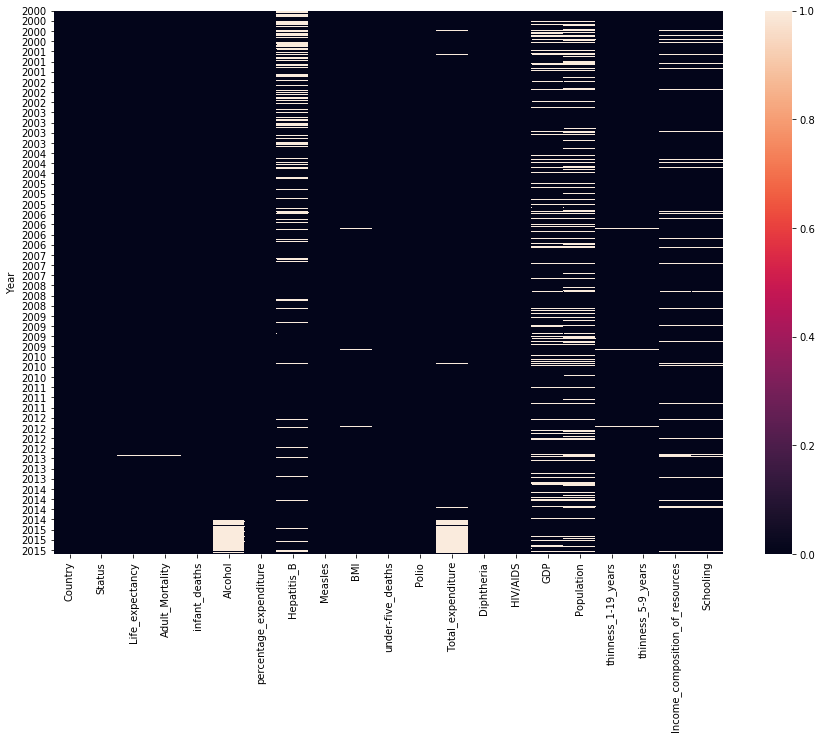

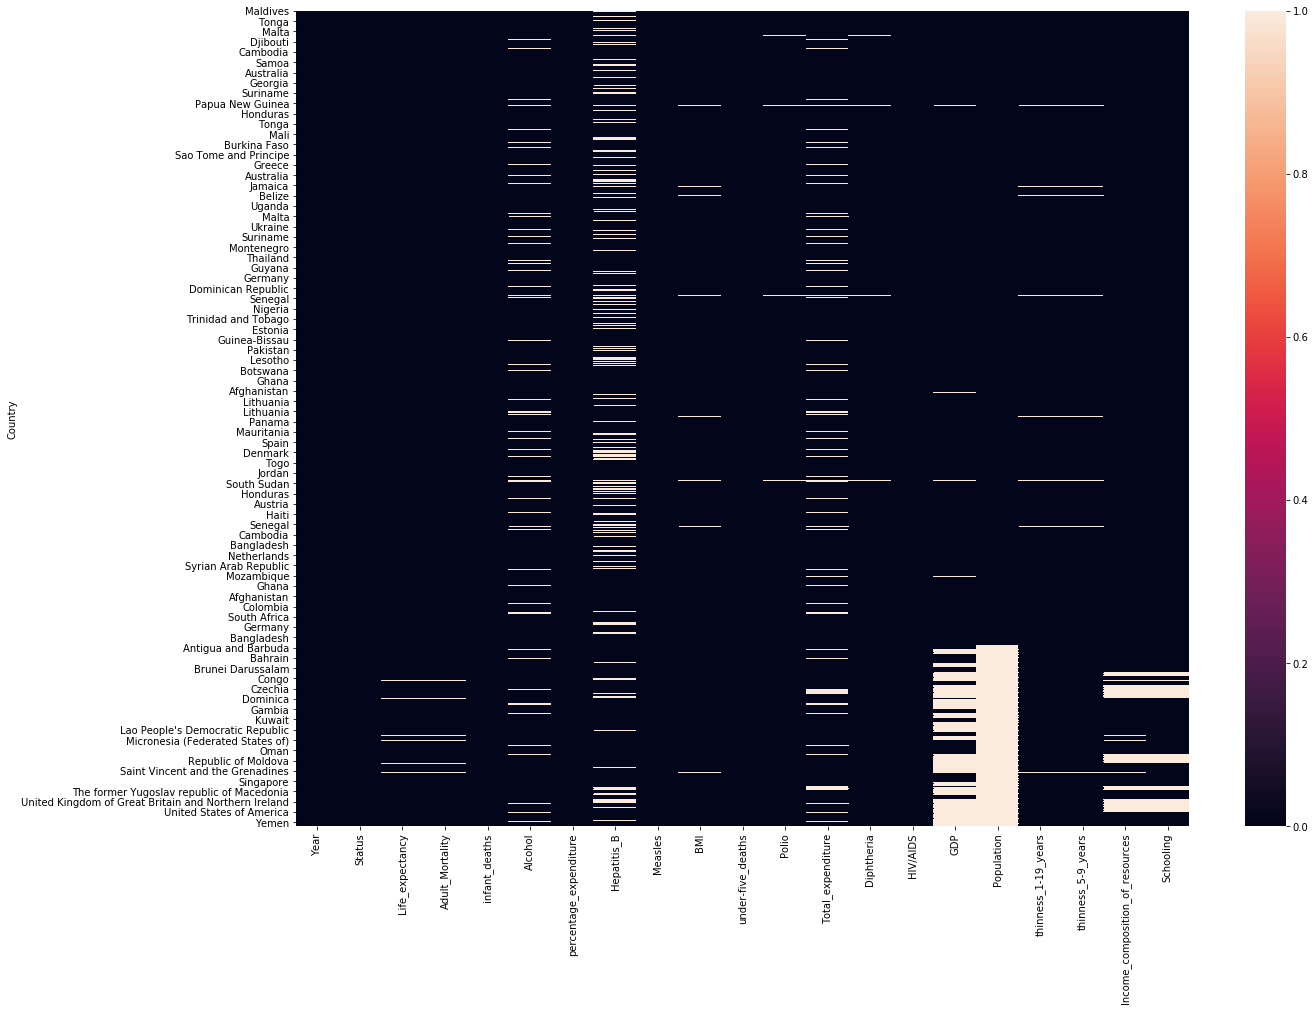

<IPython.core.display.Javascript object>

In [11]:
# Look at whether missing values are associated with certain years or countries
plt.figure(figsize=(15, 10))
sns.heatmap(pd.isnull(df1.set_index(["Year"]).sort_index()))
plt.show()

# This doesn't really tell you too much because the countries are too small
# plt.figure(figsize=(20, 15))
# sns.heatmap(pd.isnull(df1.set_index(["Country"]).sort_index()))
# plt.show()

plt.figure(figsize=(20, 15))
sns.heatmap(pd.isnull(df1.sort_values(by=["Population"]).set_index(["Country"])))
plt.show()

# not sure why this wasn't working
# plt.figure(figsize=(20, 15))
# sns.heatmap(pd.isnull(df1.set_index("Country").isnull().groupby(level=0).mean()))
# plt.show()

problematic_cols = ["Hepatitis_B", "GDP", "Population"]

* For missing values by year:
    * Looks like Alcohol and Total_expenditure don't have much information for 2015. 
    * data for Hepititus_B gets worse as you go back in time. 
    * Missing values for GDP, Population, Income_composition, and Schooling are pretty evenly distributed by year. 
        * This probably means that you just don't have the data for certain countries
* For missing values by country:
    * You do see that the GDP and Population (and to a lesser extent income composition and schooling) variables are missing in chunks, which is very weird, considering the countries are in alphabetical order.

I could do a for loop that would look at missing data by year for each country, but that would be like 180 heat maps.

Digging more into missing values by country, since it's hard to make them out on the heat map:

In [12]:
problematic_cols = ["Hepatitis_B", "GDP", "Population"]
df1.set_index("Country")[problematic_cols].isnull().groupby(level=0).mean().sort_values(
    by=["Hepatitis_B", "GDP", "Population"], ascending=False
).head(40)

Hepatitis_B     GDP  \
Country                                                                   
United Kingdom of Great Britain and Northern Ir...       1.0000  1.0000   
Denmark                                                  1.0000  0.0000   
Finland                                                  1.0000  0.0000   
Hungary                                                  1.0000  0.0000   
Iceland                                                  1.0000  0.0000   
Japan                                                    1.0000  0.0000   
Norway                                                   1.0000  0.0000   
Slovenia                                                 1.0000  0.0000   
Switzerland                                              1.0000  0.0000   
South Sudan                                              0.9375  0.5000   
Equatorial Guinea                                        0.8750  0.0000   
Somalia                                                  0.8125  0.8125   
Haiti                                                    0.8125  0.0000   
Netherlands                                              0.6875  0.0000   
Sweden                                                   0.6875  0.0000   
Ireland                                                  0.6250  0.0000   
Namibia                                                  0.6250  0.0000   
Central African Republic                                 0.5625  0.0000   
Guinea-Bissau                                            0.5625  0.0000   
Niger                                                    0.5625  0.0000   
Chad                                                     0.5000  0.0000   
Liberia                                                  0.5000  0.0000   
Timor-Leste                                              0.5000  0.0000   
Togo                                                     0.5000  0.0000   
Congo                                                    0.4375  1.0000   
Democratic Republic of the Congo                         0.4375  1.0000   
Angola                                                   0.4375  0.0000   
Croatia                                                  0.4375  0.0000   
Djibouti                                                 0.4375  0.0000   
Ethiopia                                                 0.4375  0.0000   
Guinea                                                   0.4375  0.0000   
Sierra Leone                                             0.4375  0.0000   
Burkina Faso                                             0.3750  0.0000   
Cambodia                                                 0.3750  0.0000   
Chile                                                    0.3750  0.0000   
Montenegro                                               0.3750  0.0000   
The former Yugoslav republic of Macedonia                0.3125  1.0000   
Cameroon                                                 0.3125  0.0000   
Gabon                                                    0.3125  0.0000   
Guatemala                                                0.3125  0.0000   

                                                    Population  
Country                                                         
United Kingdom of Great Britain and Northern Ir...         1.0  
Denmark                                                    0.0  
Finland                                                    0.0  
Hungary                                                    0.0  
Iceland                                                    0.0  
Japan                                                      0.0  
Norway                                                     0.0  
Slovenia                                                   0.0  
Switzerland                                                0.0  
South Sudan                                                0.0  
Equatorial Guinea                                          0.0  
Somalia                                                 

<IPython.core.display.Javascript object>

In [13]:
# I can't get this to work either. Guess I'm just terrible at heatmaps?

# plt.figure(figsize=(20, 15))
# sns.heatmap(pd.isnull(df1.set_index("Country")[problematic_cols].isnull().groupby(level=0).mean().sort_values(
#     by=["Hepatitis_B", "GDP", "Population"], ascending=False
# ).head(40)), vmin=0, vmax=1)
# plt.show()


<IPython.core.display.Javascript object>

In [14]:
df1.set_index("Country")[problematic_cols].isnull().groupby(level=0).mean().sort_values(
    by=["GDP"], ascending=False
).head(40)

Hepatitis_B     GDP  \
Country                                                                   
Egypt                                                    0.0000  1.0000   
Republic of Korea                                        0.0000  1.0000   
Cook Islands                                             0.0000  1.0000   
Czechia                                                  0.1250  1.0000   
Côte d'Ivoire                                            0.0625  1.0000   
Democratic People's Republic of Korea                    0.1875  1.0000   
Democratic Republic of the Congo                         0.4375  1.0000   
Slovakia                                                 0.0000  1.0000   
The former Yugoslav republic of Macedonia                0.3125  1.0000   
San Marino                                               0.0000  1.0000   
Saint Vincent and the Grenadines                         0.1875  1.0000   
Saint Lucia                                              0.1250  1.0000   
Saint Kitts and Nevis                                    0.0000  1.0000   
Bolivia (Plurinational State of)                         0.0000  1.0000   
Gambia                                                   0.0000  1.0000   
Republic of Moldova                                      0.0000  1.0000   
Iran (Islamic Republic of)                               0.0000  1.0000   
Lao People's Democratic Republic                         0.1875  1.0000   
Micronesia (Federated States of)                         0.0000  1.0000   
Yemen                                                    0.0000  1.0000   
Viet Nam                                                 0.1875  1.0000   
Venezuela (Bolivarian Republic of)                       0.0000  1.0000   
Monaco                                                   0.0000  1.0000   
Kyrgyzstan                                               0.0000  1.0000   
United States of America                                 0.0000  1.0000   
Bahamas                                                  0.0625  1.0000   
United Republic of Tanzania                              0.1250  1.0000   
United Kingdom of Great Britain and Northern Ir...       1.0000  1.0000   
Niue                                                     0.0000  1.0000   
Congo                                                    0.4375  1.0000   
Somalia                                                  0.8125  0.8125   
South Sudan                                              0.9375  0.5000   
Syrian Arab Republic                                     0.0000  0.5000   
Eritrea                                                  0.1250  0.2500   
Iraq                                                     0.0000  0.2500   
Libya                                                    0.0000  0.2500   
Papua New Guinea                                         0.0000  0.0625   
Sao Tome and Principe                                    0.1875  0.0625   
Spain                                                    0.0000  0.0000   
Oman                                                     0.0000  0.0000   

                                                    Population  
Country                                                         
Egypt                                                     1.00  
Republic of Korea                                         1.00  
Cook Islands                                              1.00  
Czechia                                                   1.00  
Côte d'Ivoire                                             1.00  
Democratic People's Republic of Korea                     1.00  
Democratic Republic of the Congo                          1.00  
Slovakia                                                  1.00  
The former Yugoslav republic of Macedonia                 1.00  
San Marino                                                1.00  
Saint Vincent and the Grenadines                          1.00  
Saint Lucia                                             

<IPython.core.display.Javascript object>

I think a lot of my analysis is likely to focus on GDP/GDP Per cap, so I will probably drop countries for which it has no (or barely any) data. Otherwise, impute the values.

In [15]:
df1.set_index("Country")[problematic_cols].isnull().groupby(level=0).mean().sort_values(
    by=["Population"], ascending=False
).head(40)

Hepatitis_B     GDP  \
Country                                                                   
Libya                                                    0.0000  0.2500   
Congo                                                    0.4375  1.0000   
Cuba                                                     0.0000  0.0000   
Czechia                                                  0.1250  1.0000   
Côte d'Ivoire                                            0.0625  1.0000   
Democratic People's Republic of Korea                    0.1875  1.0000   
Democratic Republic of the Congo                         0.4375  1.0000   
Dominica                                                 0.0000  0.0000   
Somalia                                                  0.8125  0.8125   
Egypt                                                    0.0000  1.0000   
Singapore                                                0.0000  0.0000   
Saudi Arabia                                             0.0000  0.0000   
Gambia                                                   0.0000  1.0000   
San Marino                                               0.0000  1.0000   
Saint Vincent and the Grenadines                         0.1875  1.0000   
Grenada                                                  0.0625  0.0000   
Saint Lucia                                              0.1250  1.0000   
Saint Kitts and Nevis                                    0.0000  1.0000   
Republic of Moldova                                      0.0000  1.0000   
Republic of Korea                                        0.0000  1.0000   
Qatar                                                    0.0000  0.0000   
Iran (Islamic Republic of)                               0.0000  1.0000   
Oman                                                     0.0000  0.0000   
Niue                                                     0.0000  1.0000   
Kuwait                                                   0.0000  0.0000   
Kyrgyzstan                                               0.0000  1.0000   
Lao People's Democratic Republic                         0.1875  1.0000   
New Zealand                                              0.0000  0.0000   
Nauru                                                    0.0000  0.0000   
Marshall Islands                                         0.0000  0.0000   
Monaco                                                   0.0000  1.0000   
Cook Islands                                             0.0000  1.0000   
Slovakia                                                 0.0000  1.0000   
Micronesia (Federated States of)                         0.0000  1.0000   
Viet Nam                                                 0.1875  1.0000   
United States of America                                 0.0000  1.0000   
United Kingdom of Great Britain and Northern Ir...       1.0000  1.0000   
United Arab Emirates                                     0.0000  0.0000   
Bahrain                                                  0.0000  0.0000   
Bolivia (Plurinational State of)                         0.0000  1.0000   

                                                    Population  
Country                                                         
Libya                                                      1.0  
Congo                                                      1.0  
Cuba                                                       1.0  
Czechia                                                    1.0  
Côte d'Ivoire                                              1.0  
Democratic People's Republic of Korea                      1.0  
Democratic Republic of the Congo                           1.0  
Dominica                                                   1.0  
Somalia                                                    1.0  
Egypt                                                      1.0  
Singapore                                                  1.0  
Saudi Arabia                                            

<IPython.core.display.Javascript object>

You can see that a lot of countries are missing all their Hep B data as well as GDP and Population (which seem to go together).

Perhaps I should make percentage change columns and use those to find the outliers if the year to year change > some percentage, probably wrong data entry: shift both the year and the column, use those to calculate geometric average change or maybe I could use logs for this. put change in a new column (I would need to take the x root, x being the number of years between that observation and the last)


* Looks like Alcohol and Total_expenditure don't have much information for 2015. 
* data for Hepititus_B gets worse as you go back in time. 
* Missing values for GDP, Population, Income_composition, and Schooling are pretty evenly distributed by year

## Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy. ##



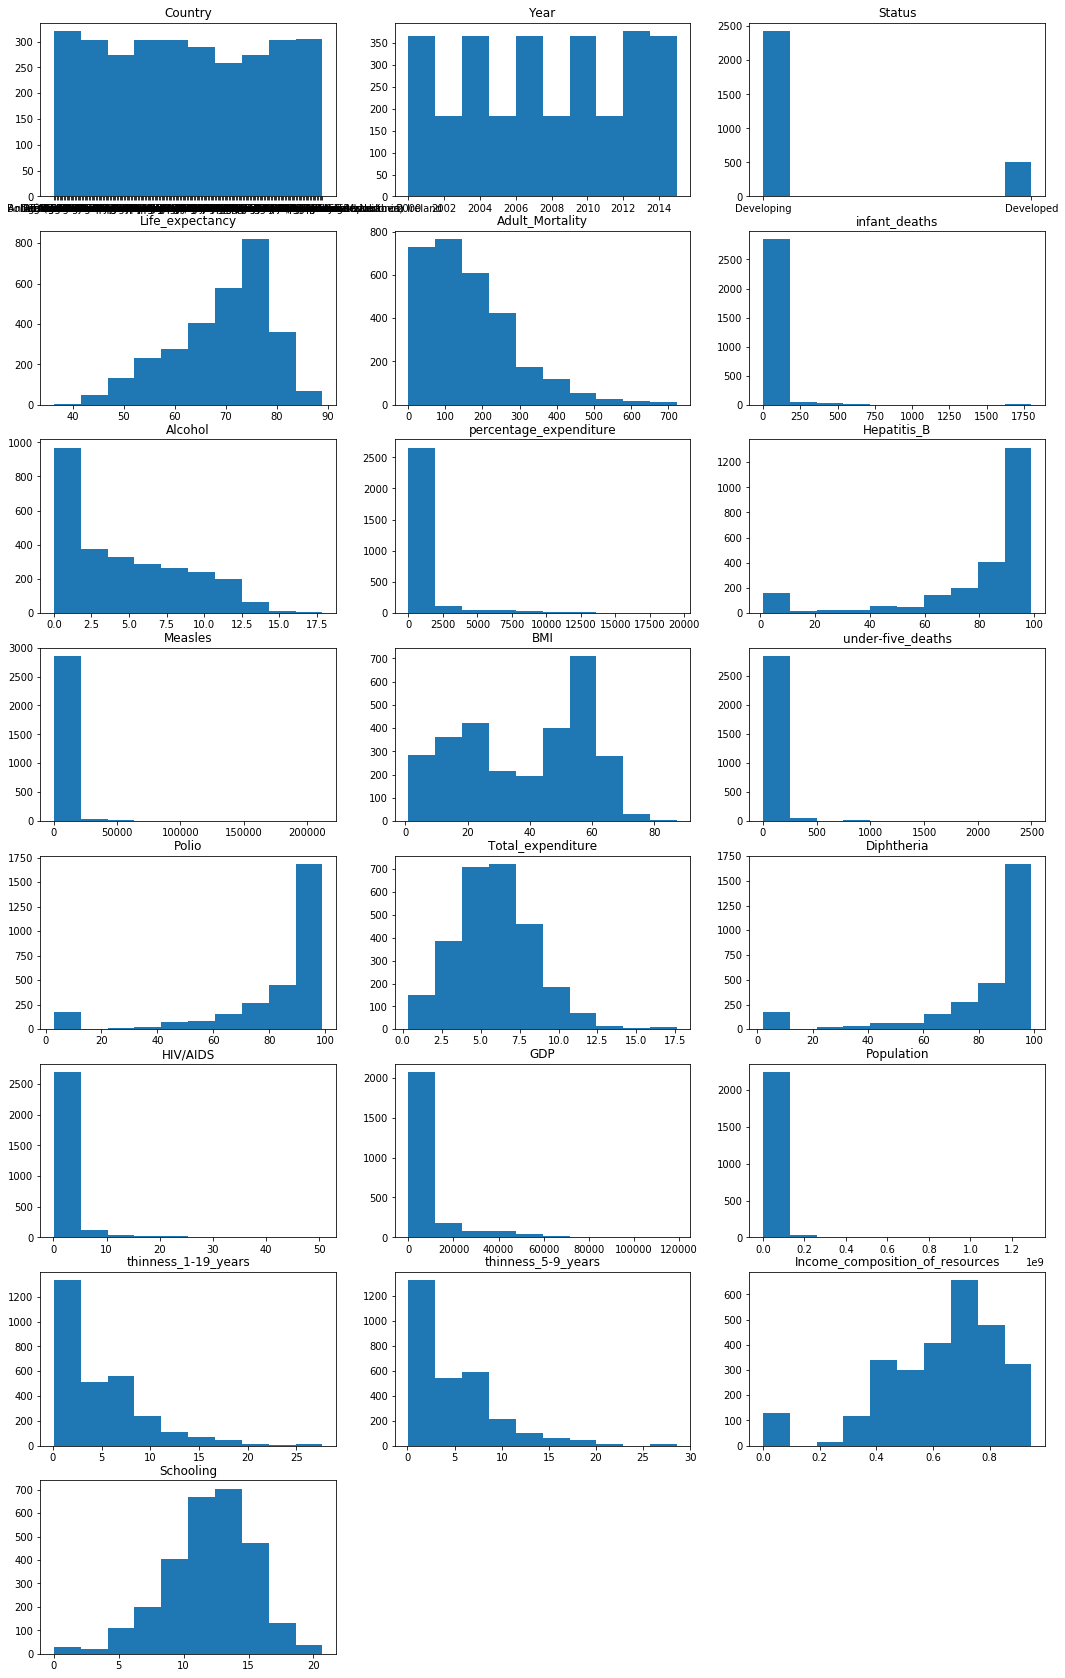

<IPython.core.display.Javascript object>

In [16]:
# first, check out some of the distributions of the variables. See if there are any
# irregularities. (eg. coding errors where missing values are coded as 0)
plt.figure(figsize=(18, 30))
count = 1
for col in df1:
    plt.subplot(8, 3, count)
    plt.hist(df1[col])
    plt.title(col)
    count = count + 1
plt.show()

* Most of these look alright, though I might need to look at boxplots. The log of gdp/ transforming it to gdp per capita may help. 
* I'm not sure what income composition of resourses is, but there are a lot of 0 values. 

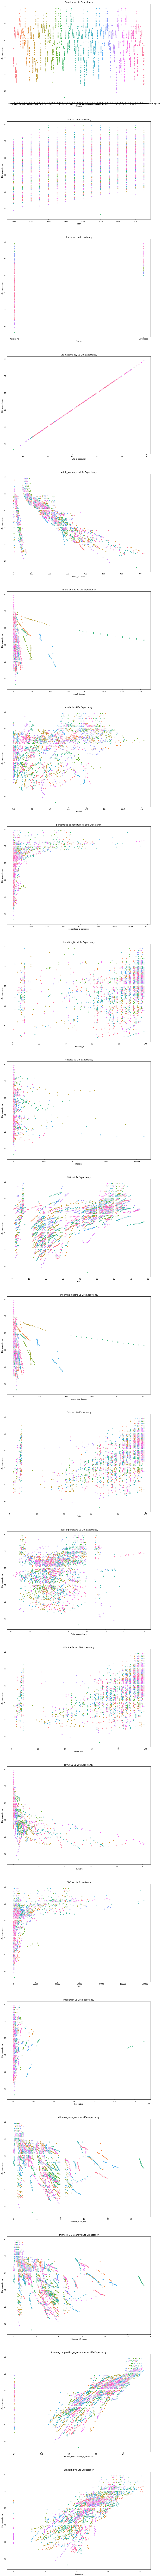

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(15, 300))
count = 1
for col in df1:
    plt.subplot(24, 1, count)
    sns.scatterplot(
        x=col,
        y="Life_expectancy",
        hue="Country",
        # size="Population",
        style="Status",
        legend=False,
        data=df1,
    )
    # plt.xticks(rotation=45)
    plt.title(col + " vs Life Expectancy")
    count = count + 1
plt.show()

Initial points:
* You can see individual countries charting their path here. You can also see that there are some outliers/entry errors in population.
    * Some things that are made clear by looking at the paths of individual countries are that 
* The country plot should be a bar chart, the year one should be a line plot vs the mean per year, and the 'status' plot should be a boxplot.
* I suspect that the percentage expenditure column is so messed up that it should just be dropped.

Most interesting graphs/features:
1. You can see a few probable outliers in the country plot. Could they be due to war/disease? Or bad data?
    * I'll revisit this plot with a better graph
2. For the adult mortality/LE scatter, you can see there are effectively two different paths. This involves a lot of different countries so I don't think it's a data entry error.
    * Basically, there was a group of countries with a lower mortality than you would expect for their life expectancy.
        * I suspect that this is a group of countries that are developing extremely quickly right now (like the BRIC + successful city states like Singapore) where adult mortality is quite low, but the life expectancy stats haven't caught up.
        * Are these outliers that should be excluded from analysis? Will they be caught by something like zscores per country? Check this!
3. You can see a few countries having a lot of success with reducing infant death.
    * If I were to look at outliers per country, they wouldn't be recognized as such. If I were to look at outliers over the whole dataset, they would probably be outliers. Should they (the countries that started with high mortality rates) be categorized as them?? Their experience with reducing it is probably valuable information.
4. Percentage expenditure (what I suspect is 1 - the savings rate) is probably just almost multicolinear with gdp per capita since richer countries tend to save less. I don't think this will be useful.
5. You see a group of data points with very low hep b figures. Could this be an affect of underreporting? Are there certain cultures in which you would be less likely to report this data even though it exists? 
6. Measles is almost eradicated. You won't get anything here. Even if you were, it would be likely captured by the adult mortality rates.
7. To me, BMI is where you can see the clearest correlation with life expectancy, both on the intra- and inter-country level.
    * It's also the clearest/prettiest graph.
    * You do see a group of countries with weirdly low bmi for their life expecancy. Is it pattern breaking? TODO: check this!
        * TODO: A cursory glance at worldwide country means of bmi reveals that they rarely fall below 20, so a lot of that is input error.
8. It looks like the same 'outlier countries' are also having success (well, perhaps they're getting worse) with infant mortality. I think that you will see a lot of co-linearity here with infant mortality.
9. For the polio data you are also seeing a group of country-years (around the same size) with a weirdly low incidence of (non) Polio rates.
    * **I suspect this means a) the outliers are due to input error b) that if I were to identify these outliers and drop them, they would be dropped everywhere.**
10. Total expenditure makes very little sense as a predictive variable. We want to look at population rate stats
    * You can see this in the scatterplot, which is just a blob.
11. Diptheria
    * seeing that group on the left again
    * There looks like a positive correlation, which makes no sense.
        * Perhaps it takes a decent amount of money to detect the disease, so this variable will be correlated with gdp per cap and so should be dropped anyway.
12. All the predictive benefits of GDP will likely be better captured by a per capita figure
13. The apparent positive correlation between population and life expectancy is likely due to population's positive correlation with 'Year'/Gdp per capita. Year because you see general public health advancements as time goes on and gdp per capita tends to grow with time which also grows with population.
    * I would like to see the effect of population controlling for GDP. Does overcrowing negatively impact health without the associated income benefits of economic growth?
14. One thing that you probably wouldn't be able to tell without the hues by country is the negative correlation between thinness and life expecancy.
    * Being less thin in childhood is associated with greater life expectancy, on the level of the individual country.
15. **You can see a lot of 0s in income composition and schooling, likely an indication of data error/outliers. Should drop!

[]

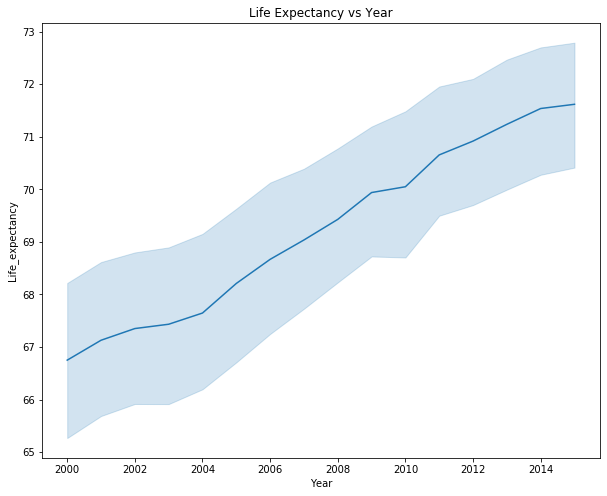

<IPython.core.display.Javascript object>

In [18]:
# A few graphs for the categorical data:
plt.figure(figsize=(10, 8))

# You don't get too much data from the following commented out graph, but you do see a huge drop in one country in 2010, probably
# bad data
# sns.lineplot(x="Year", y="Life_expectancy", hue="Country", legend=False, data=df1)
sns.lineplot(x="Year", y="Life_expectancy", legend=False, data=df1)
plt.title('Life Expectancy vs Year')
plt.plot()



[]

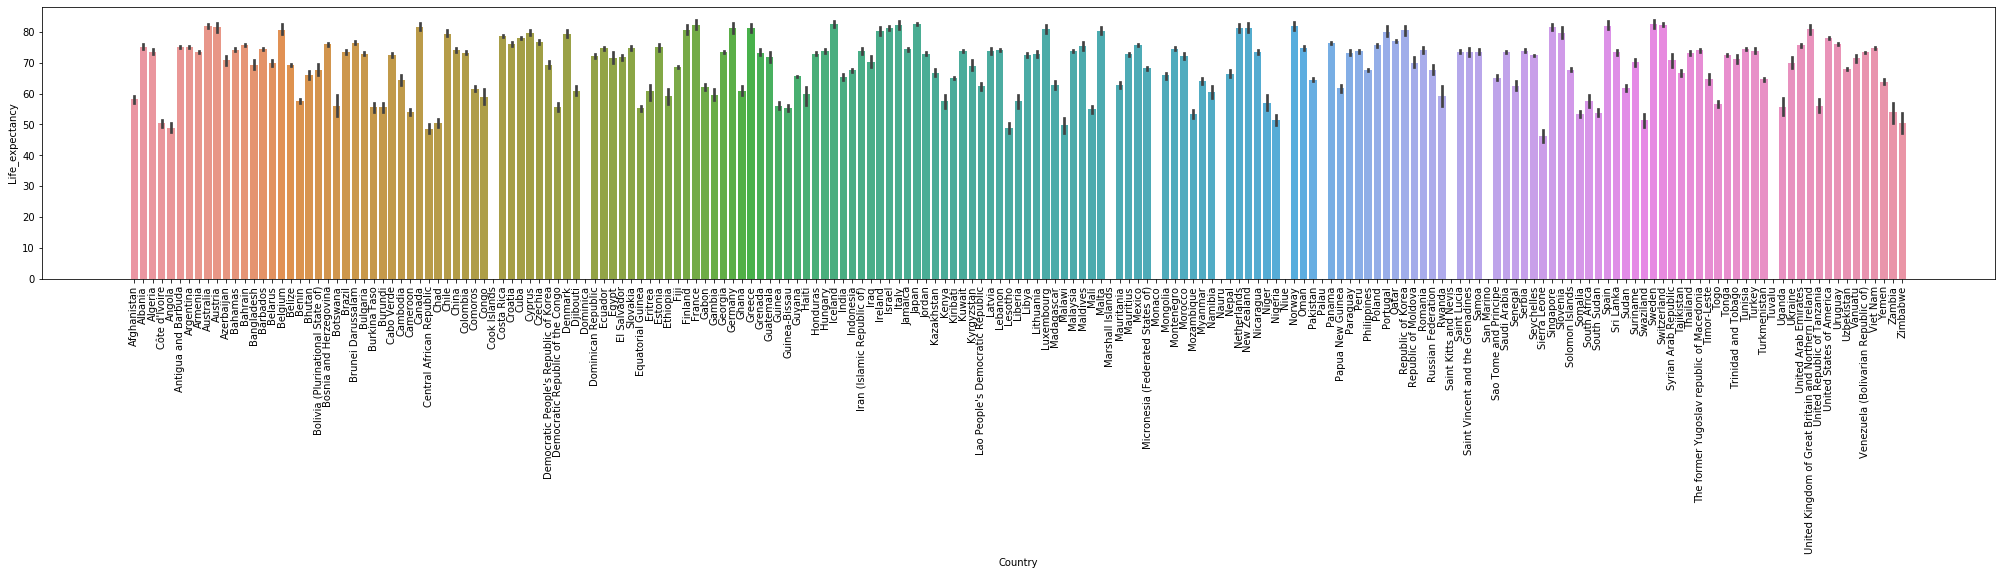

<IPython.core.display.Javascript object>

In [19]:
plt.figure(figsize=(35, 5))

sns.barplot(x="Country", y="Life_expectancy", data=df1)
plt.xticks(rotation=90)
plt.plot()

You can see that some countries have no life expectancy data above.

[]

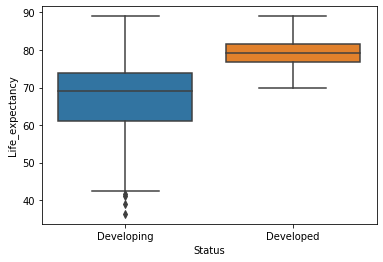

<IPython.core.display.Javascript object>

In [20]:
sns.boxplot(x="Status", y="Life_expectancy", data=df1)
plt.plot()

In [21]:
# Get rid of data entry errors:
# from looking at the graphs above, it seemed

<IPython.core.display.Javascript object>

# Dealing with missing data #

NameError: name 'country_missing_df' is not defined

<IPython.core.display.Javascript object>

In [23]:
# We've seen that some countries are missing data for basically all their years in a column.
# there is no way to impute this, so we should get rid of it
# The arbitrary amount I'm going to choose is if a country is missing more than 70% of its data for a column,
# drop that country
country_missing_df = df1.set_index("Country").isnull().groupby(level=0).mean()
print(country_missing_df.shape)
drop_countries = set()
for col in country_missing_df:
    high_missing = country_missing_df[country_missing_df[col] > 0.7]
    drop_countries.update(list(high_missing.index))
    print(col, list(high_missing.index))
# list(country_missing_df.index)
# print(drop_countries),
print(len(drop_countries))

list(np.where(country_missing_df["Population"] > 0.9))

(193, 21)
Year []
Status []
Life_expectancy ['Cook Islands', 'Dominica', 'Marshall Islands', 'Monaco', 'Nauru', 'Niue', 'Palau', 'Saint Kitts and Nevis', 'San Marino', 'Tuvalu']
Adult_Mortality ['Cook Islands', 'Dominica', 'Marshall Islands', 'Monaco', 'Nauru', 'Niue', 'Palau', 'Saint Kitts and Nevis', 'San Marino', 'Tuvalu']
infant_deaths []
Alcohol ['Palau', 'South Sudan']
percentage_expenditure []
Hepatitis_B ['Denmark', 'Equatorial Guinea', 'Finland', 'Haiti', 'Hungary', 'Iceland', 'Japan', 'Norway', 'Slovenia', 'Somalia', 'South Sudan', 'Switzerland', 'United Kingdom of Great Britain and Northern Ireland']
Measles []
BMI ['Monaco', 'San Marino', 'South Sudan', 'Sudan']
under-five_deaths []
Polio []
Total_expenditure ["Democratic People's Republic of Korea", 'Somalia', 'South Sudan']
Diphtheria []
HIV/AIDS []
GDP ['Bahamas', 'Bolivia (Plurinational State of)', 'Congo', 'Cook Islands', 'Czechia', "Côte d'Ivoire", "Democratic People's Republic of Korea", 'Democratic Republic of the C

[array([  4,  10,  11,  13,  19,  23,  37,  38,  41,  43,  44,  45,  46,
         49,  52,  62,  67,  78,  89,  90,  91,  96, 105, 109, 110, 117,
        120, 124, 126, 136, 137, 138, 142, 143, 144, 146, 148, 153, 154,
        157, 170, 181, 182, 183, 184, 188, 189, 190])]

<IPython.core.display.Javascript object>

It seems like most of the concentrated missing data is coming from GDP, so now I have a decision, should I drop GDP/population, or drop around 1/3 of the countries?

I think it will be more informative to work with gdp per capita, so I'll drop them:

In [24]:
print(df1.isnull().sum() / df1.isnull().count())
clean_df1 = df1[~df1["Country"].isin(drop_countries)]
print(clean_df1.isnull().sum() / clean_df1.isnull().count())

print(clean_df1.shape)
# lost around 700 rows, which is 25% or so, but now I can impute witout fear.
for col in clean_df1:
    clean_df1[col]=clean_df1.groupby('Country')[col].apply(lambda x : x.interpolate(limit_direction = "both"))
print(clean_df1.isnull().sum() / clean_df1.isnull().count())


Country                            0.000000
Year                               0.000000
Status                             0.000000
Life_expectancy                    0.003404
Adult_Mortality                    0.003404
infant_deaths                      0.000000
Alcohol                            0.066031
percentage_expenditure             0.000000
Hepatitis_B                        0.188223
Measles                            0.000000
BMI                                0.011572
under-five_deaths                  0.000000
Polio                              0.006467
Total_expenditure                  0.076923
Diphtheria                         0.006467
HIV/AIDS                           0.000000
GDP                                0.152485
Population                         0.221920
thinness_1-19_years                0.011572
thinness_5-9_years                 0.011572
Income_composition_of_resources    0.056841
Schooling                          0.055480
dtype: float64
Country          

<IPython.core.display.Javascript object>

In [25]:
clean_df1.head()

Country  Year      Status  Life_expectancy  Adult_Mortality  \
0  Afghanistan  2015  Developing             65.0            263.0   
1  Afghanistan  2014  Developing             59.9            271.0   
2  Afghanistan  2013  Developing             59.9            268.0   
3  Afghanistan  2012  Developing             59.5            272.0   
4  Afghanistan  2011  Developing             59.2            275.0   

   infant_deaths  Alcohol  percentage_expenditure  Hepatitis_B  Measles   BMI  \
0             62     0.01               71.279624         65.0     1154  19.1   
1             64     0.01               73.523582         62.0      492  18.6   
2             66     0.01               73.219243         64.0      430  18.1   
3             69     0.01               78.184215         67.0     2787  17.6   
4             71     0.01                7.097109         68.0     3013  17.2   

   under-five_deaths  Polio  Total_expenditure  Diphtheria  HIV/AIDS  \
0                 83    6.0               8.16        65.0       0.1   
1                 86   58.0               8.18        62.0       0.1   
2                 89   62.0               8.13        64.0       0.1   
3                 93   67.0               8.52        67.0       0.1   
4                 97   68.0               7.87        68.0       0.1   

          GDP  Population  thinness_1-19_years  thinness_5-9_years  \
0  584.259210  33736494.0                 17.2                17.3   
1  612.696514    327582.0                 17.5                17.5   
2  631.744976  31731688.0                 17.7                17.7   
3  669.959000   3696958.0                 17.9                18.0   
4   63.537231   2978599.0                 18.2                18.2   

   Income_composition_of_resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5

<IPython.core.display.Javascript object>

## Dealing with outliers ##

We got a taste for the outliers above in the scatterplots, along with certain things to remember (a group of countries have BMIs that don't exist in the world right now; there was consistently a group of about the same size that had low numbers, some countries had 0 for their income composition/schooling---seems like these two completely overlap after some analysis)

In [26]:
# Dealing with some manually:
print("Countries with weirdly low statistics in BMI, income comp, and schooling: ")
print(clean_df1[clean_df1["BMI"] < 10]["Country"].value_counts()[0:30])
print(
    clean_df1[clean_df1["Income_composition_of_resources"] == 0][
        "Country"
    ].value_counts()[0:30]
)
print(clean_df1[clean_df1["Schooling"] == 0]["Country"].value_counts()[0:30])
# It seems like most of these values are just one-offs, so probably best delete them
clean_df2 = clean_df1.copy()


clean_df2 = clean_df2[clean_df2["BMI"] > 10]
clean_df2 = clean_df2[clean_df2["Income_composition_of_resources"] != 0]
clean_df2 = clean_df2[clean_df2["Schooling"] != 0]
clean_df2.head(2)

Countries with weirdly low statistics in BMI, income comp, and schooling: 
Portugal                 4
Mozambique               3
Sao Tome and Principe    3
Liberia                  3
Luxembourg               3
Thailand                 3
South Africa             3
Lithuania                3
Belgium                  3
Djibouti                 3
China                    3
Belize                   3
Guinea-Bissau            2
El Salvador              2
Swaziland                2
Mauritius                2
Germany                  2
Nicaragua                2
Guinea                   2
Ecuador                  2
Gabon                    2
Madagascar               2
Paraguay                 2
Benin                    2
Canada                   2
Comoros                  2
France                   2
Armenia                  2
Zambia                   2
Jordan                   2
Name: Country, dtype: int64
Bhutan                    11
Turkmenistan              11
Kiribati                   6


Country  Year      Status  Life_expectancy  Adult_Mortality  \
0  Afghanistan  2015  Developing             65.0            263.0   
1  Afghanistan  2014  Developing             59.9            271.0   

   infant_deaths  Alcohol  percentage_expenditure  Hepatitis_B  Measles   BMI  \
0             62     0.01               71.279624         65.0     1154  19.1   
1             64     0.01               73.523582         62.0      492  18.6   

   under-five_deaths  Polio  Total_expenditure  Diphtheria  HIV/AIDS  \
0                 83    6.0               8.16        65.0       0.1   
1                 86   58.0               8.18        62.0       0.1   

          GDP  Population  thinness_1-19_years  thinness_5-9_years  \
0  584.259210  33736494.0                 17.2                17.3   
1  612.696514    327582.0                 17.5                17.5   

   Income_composition_of_resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0

<IPython.core.display.Javascript object>

Now to look at all the box plots:

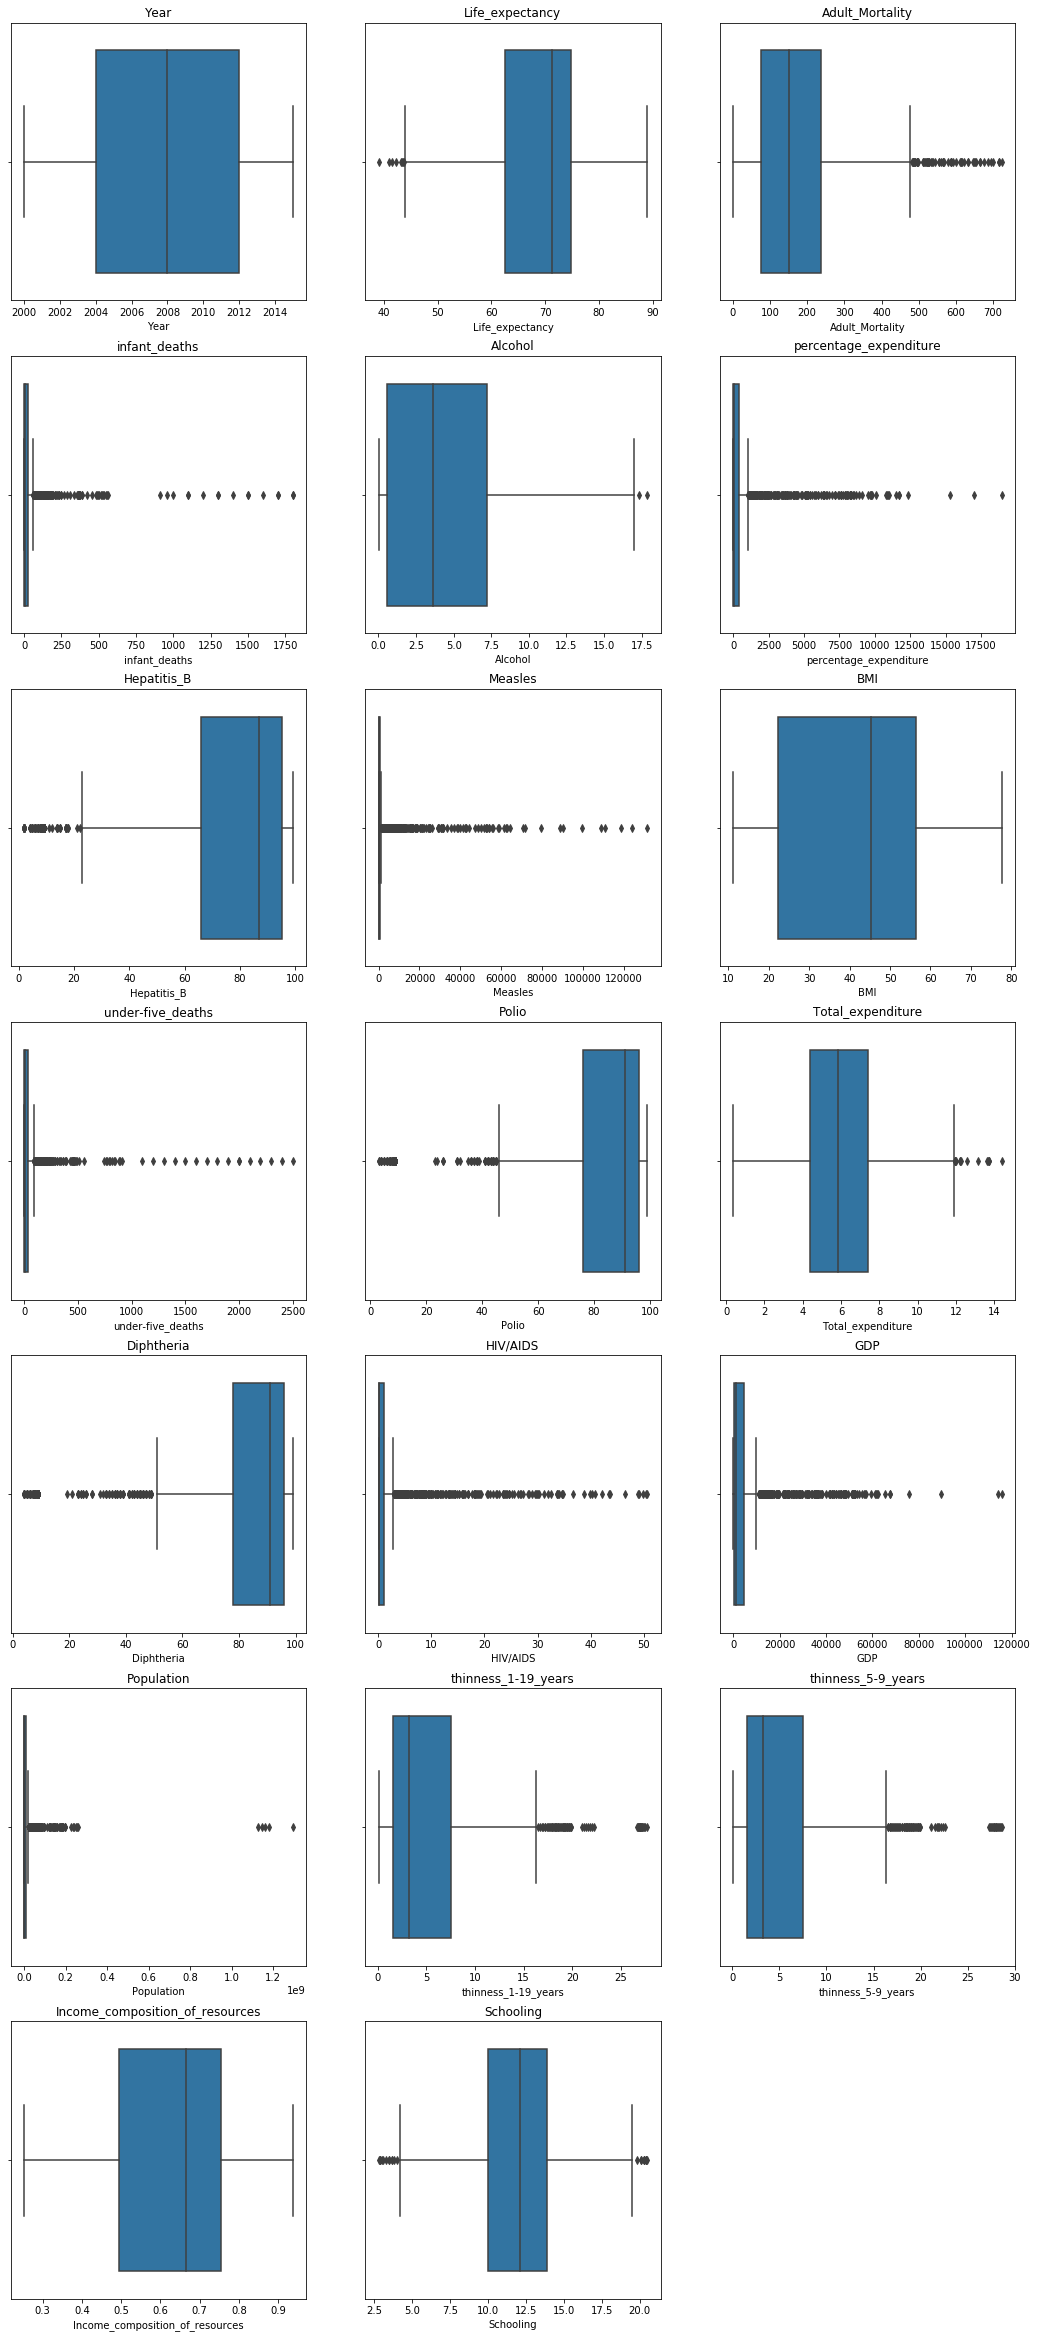

<IPython.core.display.Javascript object>

In [27]:
plt.figure(figsize=(18, 48))
count = 1
for col in clean_df2.select_dtypes("number").columns:
    plt.subplot(8, 3, count)
    sns.boxplot(x=col, data=clean_df2)
    plt.title(col)
    count = count + 1
plt.show()

You can see that certain variables here contain tons of outliers, like many of the health measures and percentage expenditure. I would like to calculate the outliers on a countrywise basis, so I'll use a groupby function.

I'm going to define my outliers according to tukey's method, using .5 iqrs as my threshold for each country. First, however, I'll look for data entry errors by looking at the percentage change

In [28]:
# From the above data, it seems like you can see the data entry errors when there is a difference of magnitude
# in the year to year change, so I should create a dataframe of the percentage changes and filter based on that

# if the percentage change is greater than 500% or less than -80%, both up and down, then it's a
# data entry error
chg_df = clean_df2.copy()
chg_df = chg_df.drop(columns=["Status"])
chg_df1 = chg_df.groupby(by=["Country"]).pct_change(periods=1)
chg_df2 = chg_df.groupby(by=["Country"]).pct_change(periods=-1)

jumps = chg_df1[chg_df1 > 5] + chg_df2[chg_df2 > 5]
decreases = chg_df1[chg_df1 < -0.8] + chg_df2[chg_df2 < -0.8]
print("See which columns had the most 500% increases or 80% decreases")
print(decreases.count())
print(jumps.count())
# It seems like the best way to go about fixing this is to interpolate them.
# clean_df3.drop(columns=["Status", 'Country']).mask(decreases.notnull(), np.nan).head(20)
# unfortunately this doesn't seem
clean_df3 = clean_df2.select_dtypes("number").mask(decreases.notnull(), np.nan)
clean_df3["Country"] = clean_df2["Country"]
clean_df3["Status"] = clean_df2["Status"]

for col in clean_df3:
    clean_df3[col] = clean_df3.groupby("Country")[col].apply(
        lambda x: x.interpolate(limit_direction="both")
    )
clean_df3.head(30)

See which columns had the most 500% increases or 80% decreases
Year                                 0
Life_expectancy                      0
Adult_Mortality                    152
infant_deaths                        1
Alcohol                              0
percentage_expenditure             207
Hepatitis_B                         59
Measles                             96
BMI                                  0
under-five_deaths                    0
Polio                               64
Total_expenditure                   11
Diphtheria                          64
HIV/AIDS                             0
GDP                                232
Population                         298
thinness_1-19_years                  1
thinness_5-9_years                   1
Income_composition_of_resources      0
Schooling                            0
dtype: int64
Year                                 0
Life_expectancy                      0
Adult_Mortality                     20
infant_deaths              

Year  Life_expectancy  Adult_Mortality  infant_deaths  Alcohol  \
0   2015             65.0            263.0           62.0     0.01   
1   2014             59.9            271.0           64.0     0.01   
2   2013             59.9            268.0           66.0     0.01   
3   2012             59.5            272.0           69.0     0.01   
4   2011             59.2            275.0           71.0     0.01   
5   2010             58.8            279.0           74.0     0.01   
6   2009             58.6            281.0           77.0     0.01   
7   2008             58.1            287.0           80.0     0.03   
8   2007             57.5            295.0           82.0     0.02   
9   2006             57.3            295.0           84.0     0.03   
10  2005             57.3            291.0           85.0     0.02   
11  2004             57.0            293.0           87.0     0.02   
12  2003             56.7            295.0           87.0     0.01   
13  2002             56.2            305.5           88.0     0.01   
14  2001             55.3            316.0           88.0     0.01   
15  2000             54.8            321.0           88.0     0.01   
16  2015             77.8             74.0            0.0     4.60   
17  2014             77.5             79.0            0.0     4.51   
18  2013             77.2             84.0            0.0     4.76   
19  2012             76.9             86.0            0.0     5.14   
20  2011             76.6             88.0            0.0     5.37   
21  2010             76.2             91.0            1.0     5.28   
22  2009             76.1             91.0            1.0     5.79   
23  2008             75.3             50.0            1.0     5.61   
24  2007             75.9              9.0            1.0     5.58   
26  2005             73.5             15.0            1.0     5.16   
27  2004             73.0             17.0            1.0     4.54   
28  2003             72.8             18.0            1.0     4.29   
29  2002             73.3             15.0            1.0     3.73   
30  2001             73.6             14.0            1.0     4.25   

    percentage_expenditure  Hepatitis_B  Measles   BMI  under-five_deaths  \
0                71.279624         65.0   1154.0  19.1                 83   
1                73.523582         62.0    492.0  18.6                 86   
2                73.219243         64.0    430.0  18.1                 89   
3                78.184215         67.0   2787.0  17.6                 93   
4                78.931791         68.0   3013.0  17.2                 97   
5                79.679367         66.0   1989.0  16.7                102   
6                56.762217         63.0   2861.0  16.2                106   
7                25.873925         64.0   1599.0  15.7                110   
8                10.910156         63.0   1141.0  15.2                113   
9                17.171518         64.0   1990.0  14.7                116   
10               16.233792         66.0   1296.0  14.2                118   
11               15.296066         67.0    466.0  13.8                120   
12               11.089053         65.0    798.0  13.4                122   
13               16.887351         64.0   2486.0  13.0                122   
14               10.574728         63.0   8762.0  12.6                122   
15               10.424960         62.0   6532.0  12.2                122   
16              364.975229         99.0      0.0  58.0                  0   
17              428.749067         98.0      0.0  57.2                  1   
18              430.876979         99.0      0.0  56.5                  1   
19              412.443356         99.0      9.0  55.8                  1   
20              437.062100         99.0     28.0  55.1                  1   
21              392.559026         99.0     10.0  54.3                  1   
22              348.055952         98.0      0.0  53.5        

<IPython.core.display.Javascript object>

Now I can remove more traditional outliers:
    Should I do it within or between countries?
    I will do it between, because I had previously focused on within, but be pretty lenient.

In [29]:
# different options were I to find the outliers within groups and use apply


def is_outlier_std(s):
    lower_limit = s.mean() - (s.std() * 0.5)
    upper_limit = s.mean() + (s.std() * 0.5)
    return ~s.between(lower_limit, upper_limit)


# df = df[~df.groupby('Group')['count'].apply(is_outlier)]

# I think you should be fairly strict with this. There shouldn't be much variation in these statistics from year
# for a single country
def is_outlier(s):
    q75, q25 = np.percentile(s, [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr * 0.5)
    max_val = q75 + (iqr * 0.5)
    return ~s.between(min_val, max_val)


def winsorize_series(group):
    return winsorize(group, limits=[0.2, 0.2])


# for col in clean_df3.select_dtypes("number").columns[1:]:
# clean_df3 = clean_df2[~clean_df2.groupby('Country')[col].apply(is_outlier)]
# .between(min_val2, max_val2)

clean_df4 = clean_df3.copy()
print(clean_df4.shape)
# use a threshold mult of 5 because I want to be lenient here
for col in clean_df3.select_dtypes("number")[1:]:
    q75_2, q25_2 = np.nanpercentile(clean_df3[col], [75, 25])
    iqr2 = q75_2 - q25_2
    min_val2 = q25_2 - (iqr2 * 5)
    max_val2 = q75_2 + (iqr2 * 5)
    clean_df4[col] = clean_df3[clean_df3[col].between(min_val2, max_val2)][col]
clean_df4 = clean_df4.dropna()
print(clean_df4.shape)

(1816, 22)
(1293, 22)


<IPython.core.display.Javascript object>

In [30]:
list(clean_df3.select_dtypes("number").columns)

['Year',
 'Life_expectancy',
 'Adult_Mortality',
 'infant_deaths',
 'Alcohol',
 'percentage_expenditure',
 'Hepatitis_B',
 'Measles',
 'BMI',
 'under-five_deaths',
 'Polio',
 'Total_expenditure',
 'Diphtheria',
 'HIV/AIDS',
 'GDP',
 'Population',
 'thinness_1-19_years',
 'thinness_5-9_years',
 'Income_composition_of_resources',
 'Schooling']

<IPython.core.display.Javascript object>

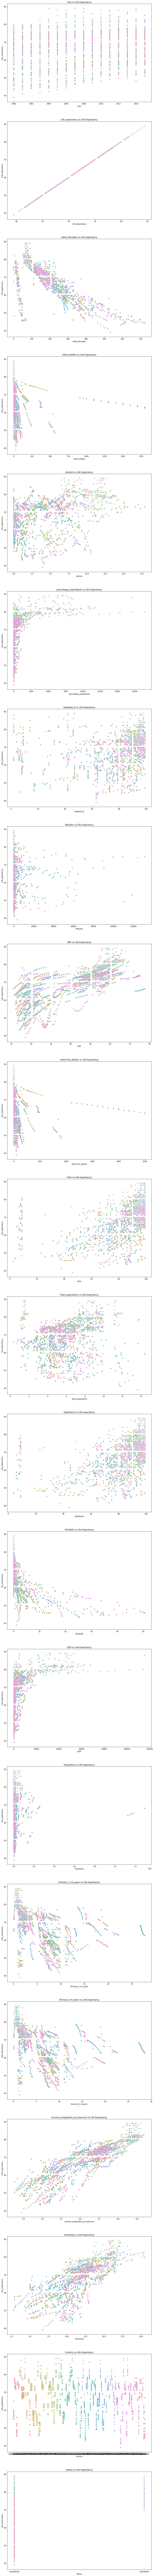

<IPython.core.display.Javascript object>

In [31]:
# finally, take a look at the scatterplots again to see if they look better.
plt.figure(figsize=(15, 300))
count = 1
for col in clean_df4:
    plt.subplot(24, 1, count)
    sns.scatterplot(
        x=col,
        y="Life_expectancy",
        hue="Country",
        # size="Population",
        style="Status",
        legend=False,
        data=clean_df3,
    )
    # plt.xticks(rotation=45)
    plt.title(col + " vs Life Expectancy")
    count = count + 1
plt.show()

In [32]:
# My final "clean" dataset
clean_df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 0 to 2923
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Year                             1293 non-null   int64  
 1   Life_expectancy                  1293 non-null   float64
 2   Adult_Mortality                  1293 non-null   float64
 3   infant_deaths                    1293 non-null   float64
 4   Alcohol                          1293 non-null   float64
 5   percentage_expenditure           1293 non-null   float64
 6   Hepatitis_B                      1293 non-null   float64
 7   Measles                          1293 non-null   float64
 8   BMI                              1293 non-null   float64
 9   under-five_deaths                1293 non-null   float64
 10  Polio                            1293 non-null   float64
 11  Total_expenditure                1293 non-null   float64
 12  Diphtheria          

<IPython.core.display.Javascript object>

## In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy. ##



In [33]:
# Create a gdp per capita column
# You will see the outliers that we saw above in population reflected here
feature_df = clean_df4.copy()
feature_df["GDP_per_cap"] = clean_df3["GDP"] / clean_df3["Population"]
feature_df["yeardiff"] = feature_df["Year"].diff()
feature_df["GDP_pc_growth"] = feature_df["GDP_per_cap"].pct_change(periods=1) + 1
feature_df = feature_df.dropna()
feature_df["GDP_pc_growth"] = feature_df["GDP_pc_growth"] ** (
    1 / feature_df["yeardiff"]
)
feature_df["GDP_pc_growth"] = feature_df["GDP_pc_growth"] - 1
print(feature_df.shape)
feature_df["status_dummy"] = feature_df["Status"] == "Developing"
feature_df["status_dummy"] = feature_df["status_dummy"].astype(int)

(1292, 25)


<IPython.core.display.Javascript object>

**Look at the features most closely associated with life expectancy**

In [34]:
# first, see the highest correlations with life expectancy
feature_df.corr().loc["Life_expectancy"].sort_values(ascending=False)

Life_expectancy                    1.000000
Income_composition_of_resources    0.879682
Schooling                          0.768382
BMI                                0.726188
GDP                                0.488042
percentage_expenditure             0.459200
Polio                              0.430766
Diphtheria                         0.418111
Alcohol                            0.413483
Hepatitis_B                        0.298668
Total_expenditure                  0.159158
GDP_per_cap                        0.097724
yeardiff                           0.041097
Year                               0.022412
GDP_pc_growth                      0.018769
Population                        -0.026387
Measles                           -0.274014
status_dummy                      -0.372584
thinness_5-9_years                -0.462313
thinness_1-19_years               -0.475358
infant_deaths                     -0.544588
under-five_deaths                 -0.594764
HIV/AIDS                        

<IPython.core.display.Javascript object>

In [35]:
feature_df.corr().loc["Life_expectancy"].abs().sort_values(ascending=False).head(10)

Life_expectancy                    1.000000
Income_composition_of_resources    0.879682
Schooling                          0.768382
Adult_Mortality                    0.767593
BMI                                0.726188
HIV/AIDS                           0.643366
under-five_deaths                  0.594764
infant_deaths                      0.544588
GDP                                0.488042
thinness_1-19_years                0.475358
Name: Life_expectancy, dtype: float64

<IPython.core.display.Javascript object>

It seems like the features most closely associated with life expectancy are some that you would expect: schooling, BMI, Adult Mortality and measurements of child health. Unfortunately, I didn't do this on a per country basis, so we could be totally ignoring the paths of individual countries.

Now to look for multicolinearity:

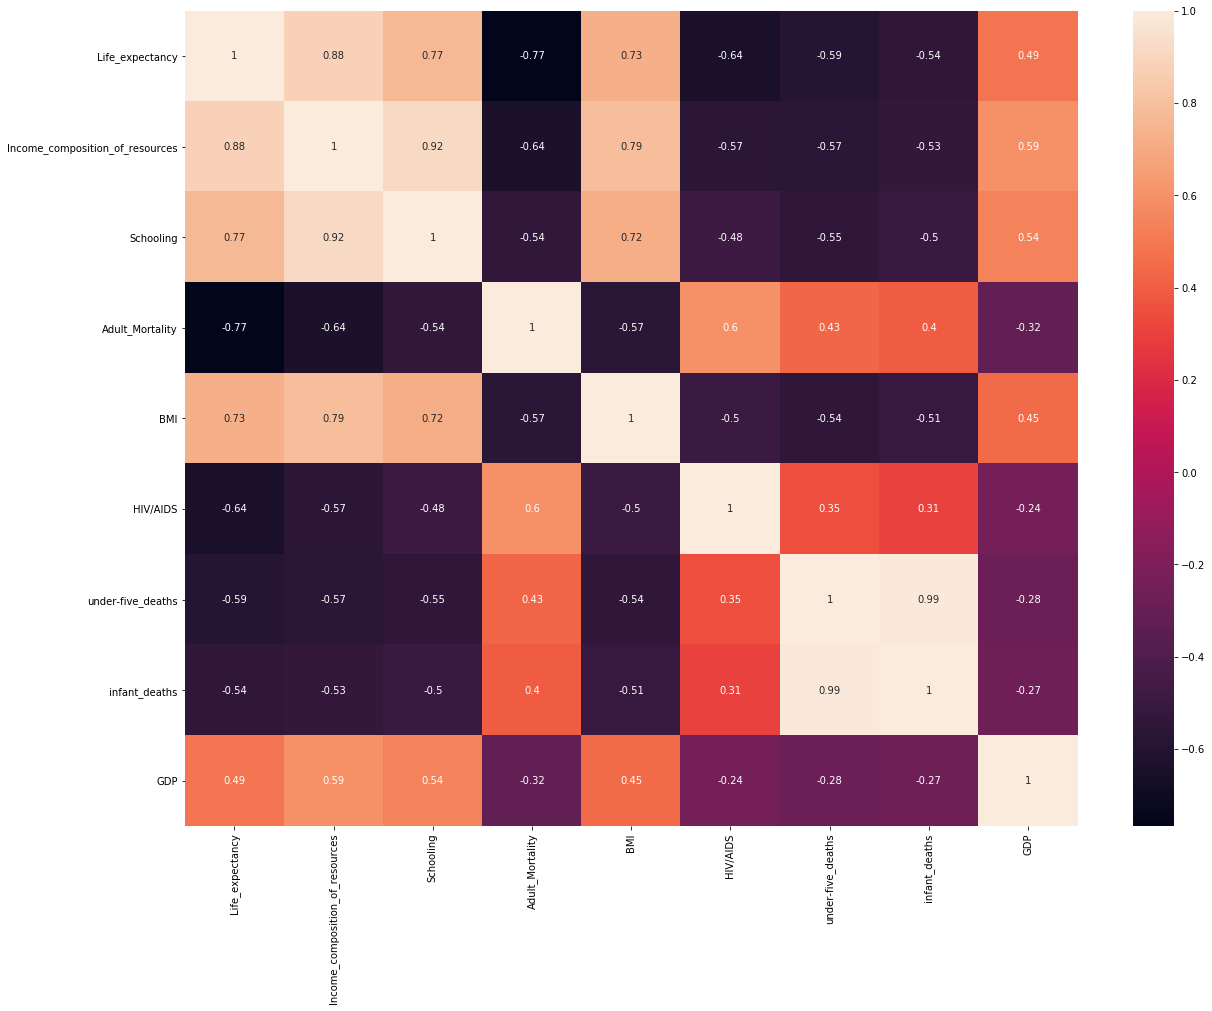

<IPython.core.display.Javascript object>

In [36]:
corr_vars = [
    "Life_expectancy",
    "Income_composition_of_resources",
    "Schooling",
    "Adult_Mortality",
    "BMI",
    "HIV/AIDS",
    "under-five_deaths",
    "infant_deaths",
    "GDP",
]
corr_df = feature_df[corr_vars].corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_df, annot=True)
plt.show()

The closest associations are between schooling and income composition, and income composition and BMI. and infant deaths and under 5 deaths.
So choices are schooling vs income comp, and income comp vs bmi.

I'm going to choose schooling and BMI, only because the income composition variable had a lot of flukey data. This is one area where a human and machine would diverge. So my final dataset is therefore:

In [37]:
# I would also include country and year to account for fixed effect and looking at growth rates
# if this were not meant for a machine learning model.
finaldataset = feature_df[
    ["Life_expectancy", "Schooling", "Adult_Mortality", "BMI", "HIV/AIDS"]
]

<IPython.core.display.Javascript object>

## Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization. ##



1. The data is not very good. Variables would swing wildly from year to year, often by a factor of 10
    * A lof of values were also coded as 0
    
The missing data distribution:

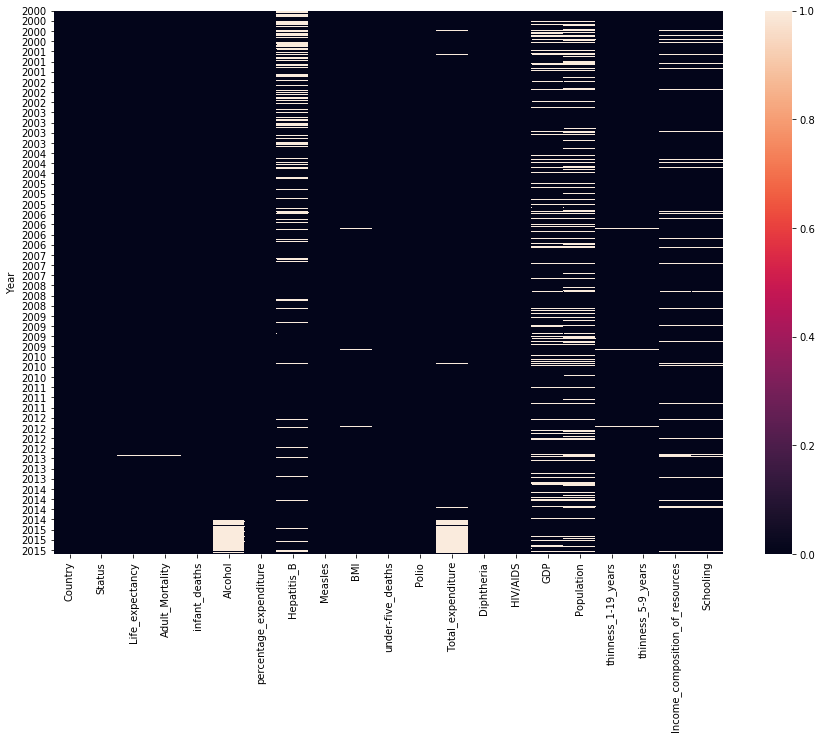

<IPython.core.display.Javascript object>

In [38]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.isnull(df1.set_index(["Year"]).sort_index()))
plt.show()

In [39]:
# Some graphs:
print("See what variables were most correlated with life expectancy: ")
feature_df[corr_vars].corr()[["Life_expectancy"]]

See what variables were most correlated with life expectancy: 


Life_expectancy
Life_expectancy                         1.000000
Income_composition_of_resources         0.879682
Schooling                               0.768382
Adult_Mortality                        -0.767593
BMI                                     0.726188
HIV/AIDS                               -0.643366
under-five_deaths                      -0.594764
infant_deaths                          -0.544588
GDP                                     0.488042

<IPython.core.display.Javascript object>

And their scatterplots:

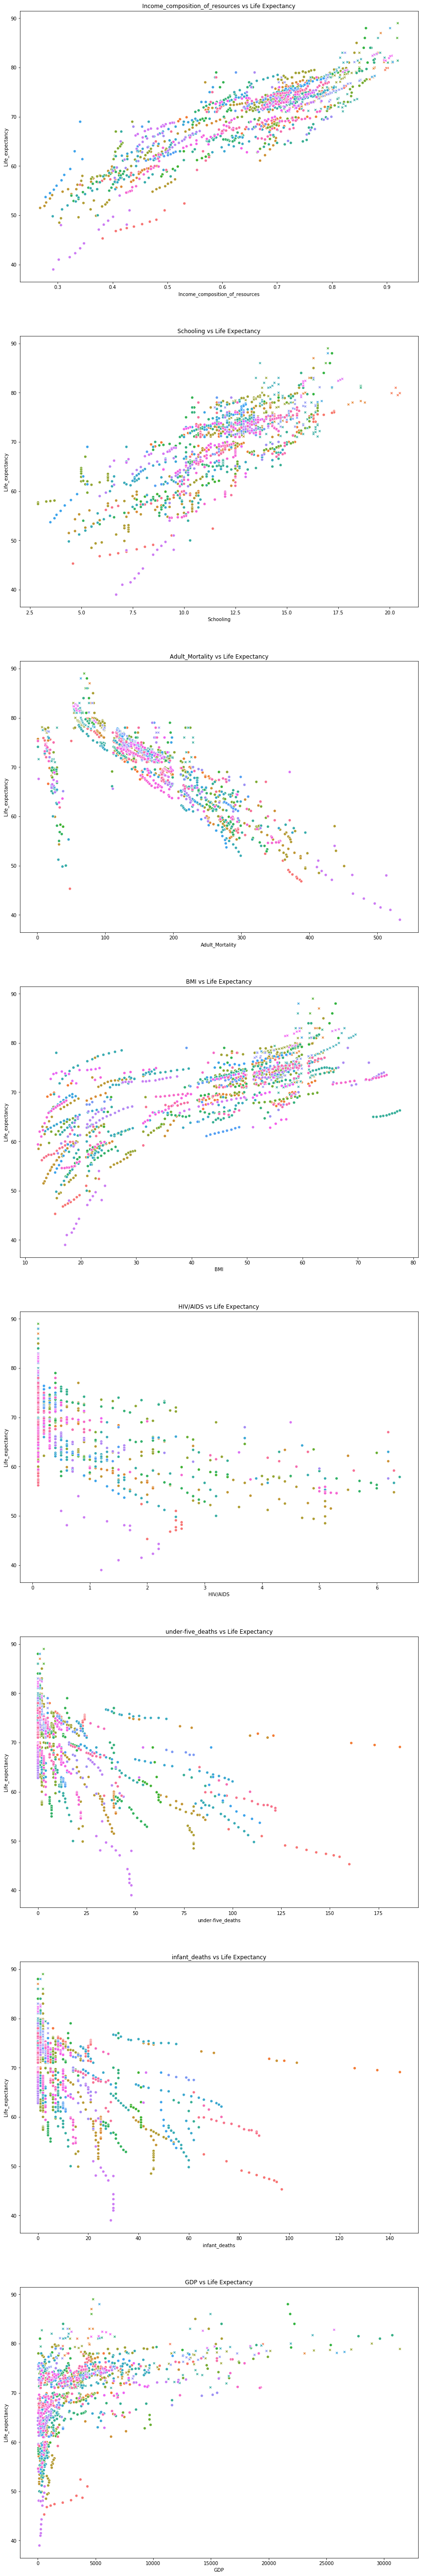

<IPython.core.display.Javascript object>

In [40]:
corrvars2=[
    #"Life_expectancy",
    "Income_composition_of_resources",
    "Schooling",
    "Adult_Mortality",
    "BMI",
    "HIV/AIDS",
    "under-five_deaths",
    "infant_deaths",
    "GDP",
]
plt.figure(figsize=(15, 300))

count2=1
for col in corrvars2:
    plt.subplot(24, 1, count2)
    sns.scatterplot(
        x=col,
        y="Life_expectancy",
        hue="Country",
        # size="Population",
        style="Status",
        legend=False,
        data=clean_df4,
    )
    # plt.xticks(rotation=45)
    plt.title(col + " vs Life Expectancy")
    count2 = count2 + 1


GDP would probably look a little better if we took the log of it. The colors are by country and the shapes are by development level.

## Final findings: ##

The obvious factors are important for life expectancy: death rates, both those of children and adults.

Furthermore, we see indications of general social well being, like schooling and income composition, as well as proxies for public health, like HIV rates and BMI

Also, GDP is an important factor. I imagine this is a proxy for gdp growth in general, which is an indication of rising wages. This 'spot' should have been taken by GDP per capita, but the population data was just too poor I suspect.

**Just to compare with sklearn's picks:**

In [41]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
selector=SelectKBest(f_regression, k=5)
X=feature_df.drop(columns=['Country', 'Life_expectancy', 'Status'])
y=feature_df['Life_expectancy']
#note, did not split into training data and test data
selector.fit(X, y)
k_best = selector.transform(X)

testdf = pd.DataFrame({"feature": X.columns, "f_score": selector.scores_})
testdf = testdf.sort_values("f_score", ascending=False)
print(testdf.head())


                            feature      f_score
17  Income_composition_of_resources  4413.921687
18                        Schooling  1859.501871
1                   Adult_Mortality  1850.208876
7                               BMI  1439.289143
12                         HIV/AIDS   911.065987


<IPython.core.display.Javascript object>

So it was the same, excepting of course income composition!